# **Classifying buildings Post Hurricane using Satellite Imagery**

## Introduction

Link to presentation: https://drive.google.com/file/d/1cs8SI4V1PAaFEPFOyeWfpeWbjxuOlUQc/view?usp=sharing <br>
Here, As part of our final project for AI2, our team comprising of **Ratna Sambhav, Suprit Choudhury, Jainam Doshi, and E Karthik Sai**  present our work on the classification of damaged buildings post hurricane. 

After a hurrican in populated as well as sparse areas of human settlements, the very next thing after human rescue is the **damage assessment**. This is very critical for emergence managers as it helps them in **efficient response and proper resource allocation**. The only way for doing this is using **ground survey or drones** to manually quantify the number of flooded or damaged buildings. But this process being **highly labour intensive and time taking**, other efficient and faster methods have to be developed. <br> 

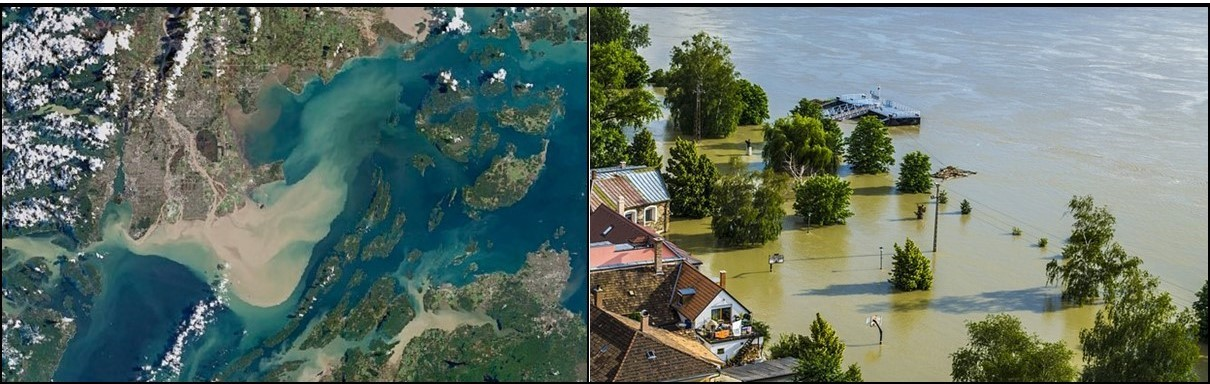
<br>
Having access to **satellite imagery**, its capabilities can easily be harnessed for this task. We can take satellite images of hurricane damaged areas, extract square size images containing one or group of buildings (using building coordinates) and use those square images to train a neural netwrok which can easily predict which building is damaged and which is not, how many buildings in a locality is damaged, etc. for any new satellite images of a particular area. This method will be **cost efficint, easier and way faster and will help emergency managers accurately plan the resource requirement and efficiently distribute resources to those in need**. <br>
In this notebook, we have used the square images of buildings in hurricane hit areas (which has been already extracted from satellite images) to train our model, to see **how much accurate a deep learning model can be in classifying damaged and not-damaged buildings, and drawing inferences as to whether this method can be used in the post-hurricane emergency situation.**<br>
<br>
Our main focus in this notebook is to see how different SOTA models perform on the given dataset for the task of classification, compare them with our custom built model and understand which part of the image any CNN model usually focusses on to be able to classify it as damaged or not-damaged. <br>
<br>
Following is the broader description of the work carried out in this notebook:
1.   **Creating an image data pipeline**: To access images as datasets, do necessary transformations and prefetching for optimal utilization computing resourses.
2.   **Building model architecture**: Creating layer by layer whole CNN network in case of custom model or importing a SOTA model, customizing it and compiling it on MultiOptimizer.
3.   **Training of model using the dataset**
4.   **Extracting inferences and comparison of model performaces**: For both balanced and unbalanced test sets.
5.   **Visualizing which part of the image model uses to make its prediction**: Using both Saliency Mapping and GradCam.

## **Ground Work**


1.   Mounting Drive
2.   Library Import



### Drive Mounting
To access the image folder on drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing the libraries
Mainly for dataset creation, moel architecture, plotting and evaluating results using standard metrics.

In [ ]:
!pip install tensorflow_addons

# Importing the necessary libraries
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

#Checking the tensorflow version
print(tf.__version__)

from IPython.display import display
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 9.5 MB/s 
2.8.2


## **Creating Image Data Pipeline**
**1.**  Image folder is imported in the form of dataset and transformations are done on it. <br>
**2.**  12 randomly selected images are looked upon to get an idea what we are dealing with.

### Building dataset from image folder
**I.** Using tensorflow_dataset library functions, folders containing images are accessed and then are splitted on the basis of sub folders i.e. train-test-validation, finally resulting in four datasets in the form of python dictionary. <br>
**II.** 'augment_image' function is then defined which takes each element (dict) of the dataset, do some manually defined image random transformations and return them as tuple containing the transformed image and its label. This function is only applied on train dataset for better generalization. <br>
**III.** 'change_form' function just converts elements of the dataset which is in the form of dictionary to tuple. This function is applied on rest of the datasets. (tuple is the prerequisite format for taining in keras models) <br>
**IV.** Train dataset is then shuffled (to get different order of images in different epochs) and then batched. All the other datasets are also batched to the same batch_size. <br>
**V.** Labels for both the test sets (balanced and unbalanced) were obtained for later use.

In [ ]:
#Accessing the dataset and converting it to dataset format
builder = tfds.ImageFolder('/content/drive/MyDrive/Colab Notebooks/AI2/AI2 Project/Post_hurricane')
train, val, test_unb, test = builder.as_dataset(split = ['train_another', 'validation_another', 'test_another', 'test'])

#Function to do random changes to the image for better generalization (also converting data to a format acceptable during training)
def augment_image(element):
    img = element['image']
    label = element['label']
    
    #Random Flipping
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_flip_left_right(img)
    
    #Random Brightness
    max_delta = 0.2
    img = tf.image.random_brightness(img, max_delta)
    
    #Random Rotation
    img = tfa.image.rotate(img, tf.random.uniform((1,), -60, 60, tf.dtypes.float32),
    interpolation = 'nearest',
    fill_mode = 'reflect') 
    
    #Random Translate
    img = tfa.image.translate(img, tf.random.uniform((2,), -10, 10, tf.dtypes.float32),
    interpolation = 'nearest',
    fill_mode = 'reflect')
    
    # Returning in the form of tuple
    return (img, label)

#Function which only change the form of each element of the dataset from a dictionary to a tuple.
def change_form(element):
    img = element['image']
    label = element['label']
    return (img, label)

# Mapping all of the elements in the train dataset with the augment_image function, shuffling and batching
train_ds = train.map(lambda x: augment_image(x)).shuffle(buffer_size=1000, seed=42).batch(32)
# Mapping rest of the dataset on change_form function for just changing its form and then batching them
val_ds = val.map(lambda x: change_form(x)).batch(32)
test_ds = test.map(lambda x: change_form(x)).batch(32)
test_unb_ds = test_unb.map(lambda x: change_form(x)).batch(32)

# Getting labels from the unbalanced and balanced test datasets (unbatch is used since dataset is now in batched form)
# y_true = [i[1] for i in test_ds.unbatch()]
# y_true_unb = [i[1] for i in test_unb_ds.unbatch()]

# Saving the labels y_true and y_true_unb for future use
# np.save('/content/drive/MyDrive/AI2_Project/Predictions/y_true_unb.npy', y_true_unb, allow_pickle=True)
# np.save('/content/drive/MyDrive/AI2_Project/Predictions/y_true.npy', y_true, allow_pickle=True)

# y_true =  np.load('/content/drive/MyDrive/AI2_Project/Predictions/y_true.npy', allow_pickle=True)
# y_true_unb = np.load('/content/drive/MyDrive/AI2_Project/Predictions/y_true_unb.npy', allow_pickle=True)

### Looking at images in the dataset
12 images are taken from one batch of transformed train dataset and plotted.

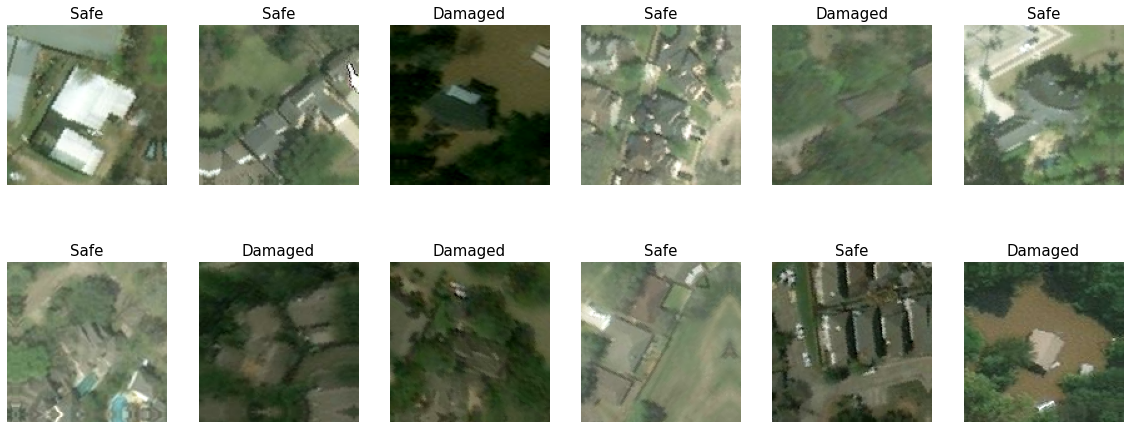

In [ ]:
# Checking on the dataset after augmentation
fig = plt.figure(figsize=(20,8))
t = 1 
class_label = ['Damaged', 'Safe']

# Taking one batch from the dataset, unbatching it and taking 12 instances to see the images
for i in train_ds.take(1).unbatch().take(12):
  ax = fig.add_subplot(2,6,t)
  ax.imshow(i[0])
  ax.set_title(class_label[int(i[1])], fontsize=15)
  ax.axis('off')
  t += 1
plt.show()

## **Custom Model**


1.   Model Architecture Construction (with regularization)
2.   Model training on training set and validation on validation set
3.   Evaluating predictions on test  (balanced and unbalanced)



### Model Architecture
In this custom model, we take the input shape as 128*128*3 and rescale it from 0 to 1. We add many 2D Convolution Layer with 64, 128, and 256 filters, and activation as a "relu" also we use Lasso Regression(L1) as a kernel regularize in some layers. We use he_uniform as a kernel initializer and take the same padding in all layers. For standardizing the inputs to the model we use Batch Normalization. To reduce the dimensionality we use Max pooling with 2*2 pool size and 2*2 stride. By using we convert more dimensional arrays into a single linear vector. We use 3 dense layers with 128, 256, and 512 filters. In a dense layer, each neuron receives input from all the neurons of the previous layer so we use a 20 percent dropout. <br>

We use a Dense layer with sigmoid activation and a single filter for the Output layer.<br>

For compile the model we use Adam an optimizer with binary crossentropy loss and accuracy metrics.

In [ ]:
# model = tf.keras.models.Sequential()

# l1_reg =  tf.keras.regularizers.L1(l1=0.001)

# input_shape =(128, 128, 3)
 
# model.add(tf.keras.layers.Input(shape=input_shape))
# # Rescaling Layer
# model.add(tf.keras.layers.Rescaling(1./255))
# # First Convolution Layer
# model.add(tf.keras.layers.Conv2D(16, kernel_size=(3,3), kernel_initializer="he_uniform", padding ="same", activation='relu'))
# # Second Convolution Layer
# model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=2, activation='relu',kernel_initializer="he_uniform",padding ="same"))
# model.add(tf.keras.layers.BatchNormalization())
# # Third Convolution Layer
# model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu',strides = 2, kernel_initializer="he_uniform",padding ="same"))
# model.add(tf.keras.layers.BatchNormalization())
# # First MaxPooling Layer
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# # Fourth convolution layer
# model.add(tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_uniform",padding="same",kernel_regularizer=l1_reg))
# model.add(tf.keras.layers.BatchNormalization())
# # Fifth convolution layer
# model.add(tf.keras.layers.Conv2D(512,(3,3),activation="relu",strides=1,kernel_initializer="he_uniform",padding="same",kernel_regularizer=l1_reg))
# model.add(tf.keras.layers.BatchNormalization())
# # Sixth convolution layer
# model.add(tf.keras.layers.Conv2D(1024,(3,3),activation="relu",kernel_initializer="he_uniform",padding="same"))
# model.add(tf.keras.layers.BatchNormalization())
# # Second MaxPooling Layer
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# # Seventh convolution layer
# model.add(tf.keras.layers.Conv2D(1024,(3,3),activation="relu",kernel_initializer="he_uniform",padding="same",kernel_regularizer=l1_reg))
# model.add(tf.keras.layers.BatchNormalization())
# # Eigth convolution layer
# model.add(tf.keras.layers.Conv2D(2048,(3,3),activation="relu",strides=1,kernel_initializer="he_uniform",padding="same",kernel_regularizer=l1_reg))
# model.add(tf.keras.layers.BatchNormalization())
# # Third MaxPooling Layer
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# #Flatten Layer
# model.add(tf.keras.layers.Flatten())

# # Fully connected dense layer
# model.add(tf.keras.layers.Dense(2048,activation="relu",kernel_initializer="he_uniform",kernel_regularizer=l1_reg))
# model.add(tf.keras.layers.BatchNormalization())
# # Fully connected dense layer
# model.add(tf.keras.layers.Dense(512,activation="relu",kernel_initializer="he_uniform",kernel_regularizer=l1_reg))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.2))
# # Fully connected dense layer
# model.add(tf.keras.layers.Dense(64,activation="relu",kernel_initializer="he_uniform",kernel_regularizer=l1_reg))
# model.add(tf.keras.layers.BatchNormalization())

# # Output layer
# model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

# adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)

# #Compiling the model
# model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

#Summary of our model
# model.summary()

In [ ]:
model = tf.keras.Sequential()

l1_reg =  tf.keras.regularizers.L1(l1=0.001)

input_shape =(128, 128, 3)

 
model.add(tf.keras.layers.Input(shape=input_shape))
# Rescaling Layer
model.add(tf.keras.layers.Rescaling(1./255))
# First Convolution Layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), kernel_initializer="he_uniform",padding ="same", activation='relu'))
# Second Convolution Layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu',kernel_initializer="he_uniform",padding ="same"))
model.add(tf.keras.layers.BatchNormalization())
# Third Convolution Layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu',strides = 2, kernel_initializer="he_uniform",padding ="same"))
model.add(tf.keras.layers.BatchNormalization())
# First MaxPooling Layer
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# Fourth convolution layer
model.add(tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_uniform",padding="same",kernel_regularizer=l1_reg))
model.add(tf.keras.layers.BatchNormalization())
# Fifth convolution layer
model.add(tf.keras.layers.Conv2D(128,(3,3),activation="relu",strides=1,kernel_initializer="he_uniform",padding="same",kernel_regularizer=l1_reg))
model.add(tf.keras.layers.BatchNormalization())
# Sixth convolution layer
model.add(tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_uniform",padding="same"))
model.add(tf.keras.layers.BatchNormalization())
# Second MaxPooling Layer
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))


#Flatten Layer
model.add(tf.keras.layers.Flatten())

# Fully connected dense layer
model.add(tf.keras.layers.Dense(256,activation="relu",kernel_initializer="he_uniform",kernel_regularizer=l1_reg))
model.add(tf.keras.layers.BatchNormalization())
# Fully connected dense layer
model.add(tf.keras.layers.Dense(512,activation="relu",kernel_initializer="he_uniform",kernel_regularizer=l1_reg))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
# Fully connected dense layer
model.add(tf.keras.layers.Dense(512,activation="relu",kernel_initializer="he_uniform",kernel_regularizer=l1_reg))
model.add(tf.keras.layers.BatchNormalization())

# Output layer
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

adam = tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, decay=0.0)

#Compiling the model
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

#Summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                        

### Training the model on the training data and evaluating on validation data
'prefetch' is used for optimal performace and 10 epochs were enough for the model to give appropriate level of accuracy in predictions. 

Epoch 1/10
313/313 [==============================] - 290s 918ms/step - loss: 20.2298 - accuracy: 0.8751 - val_loss: 16.6758 - val_accuracy: 0.5340
Epoch 2/10
313/313 [==============================] - 47s 140ms/step - loss: 12.6972 - accuracy: 0.8825 - val_loss: 10.2653 - val_accuracy: 0.6805
Epoch 3/10
313/313 [==============================] - 46s 137ms/step - loss: 7.9565 - accuracy: 0.8820 - val_loss: 6.1190 - val_accuracy: 0.7590
Epoch 4/10
313/313 [==============================] - 46s 136ms/step - loss: 4.7781 - accuracy: 0.8829 - val_loss: 3.8289 - val_accuracy: 0.8995
Epoch 5/10
313/313 [==============================] - 46s 136ms/step - loss: 3.2797 - accuracy: 0.8912 - val_loss: 3.0796 - val_accuracy: 0.6615
Epoch 6/10
313/313 [==============================] - 47s 138ms/step - loss: 2.5334 - accuracy: 0.8944 - val_loss: 2.5226 - val_accuracy: 0.9280
Epoch 7/10
313/313 [==============================] - 46s 135ms/step - loss: 2.3680 - accuracy: 0.8926 - val_loss: 2.0608 - v

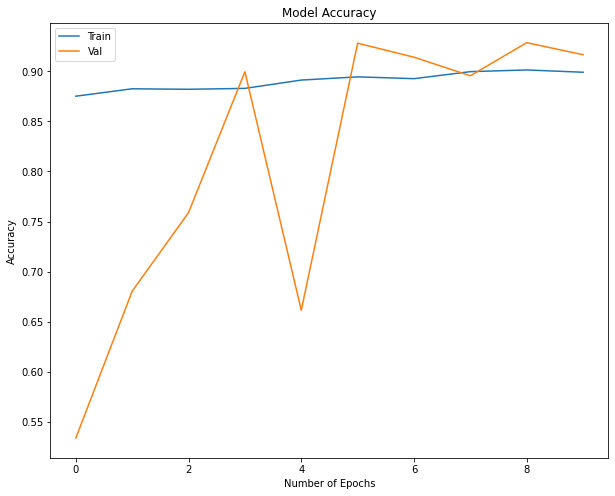

In [ ]:
# Training the model on training set and validating on validation set
# Using prefetch to distribute the task optimally between cpu and gpu.
with tf.device('/gpu:0'):
  history_custom = model.fit(train_ds.prefetch(1), 
                          epochs=10, validation_data = val_ds.prefetch(1), verbose=1)

plt.figure(figsize=(10,8))
plt.plot(history_custom.history['accuracy'])
plt.plot(history_custom.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Performance on test sets

Evaluating the model on Balanced and Unbalanced Test set

In [ ]:
# Evaluating on the test sets
test_result_custom = model.evaluate(test_ds.prefetch(1))
unbalanced_test_result_custom = model.evaluate(test_unb_ds.prefetch(1))

print('\nAccuracy on balanced test set is ',test_result_custom[1])
print('Accuracy on unbalanced test set is ',unbalanced_test_result_custom[1],'\n\n')

282/282 [==============================] - 10s 36ms/step - loss: 3.9230 - accuracy: 0.9234

Accuracy on balanced test set is  0.8815000057220459
Accuracy on unbalanced test set is  0.9234444499015808 




Testing the model performance using different metrics of evaluation

,Precision,Recall,F1_Score,ROC_AUC_Score,Accuracy Score
Unbalanced Data,0.61476,0.833,0.707431,0.883875,0.923444


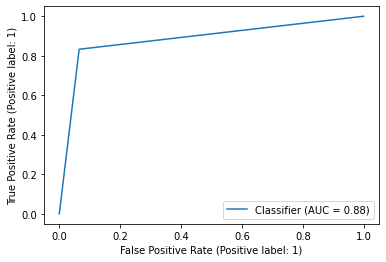

In [ ]:
# Prediction of the model on the balanced test set
test_prediction_custom_proba = model.predict(test_ds.prefetch(1)).reshape(-1,)
# Converting probabilities to classes (since obatined labels are in that form)
test_prediction_custom = [np.round(i) for i in test_prediction_custom_proba]
# Prediction of the model on the unbalanced test set
unb_test_prediction_custom_proba = model.predict(test_unb_ds.prefetch(1)).reshape(-1,)
# Converting probabilities to classes
unb_test_prediction_custom = [np.round(i) for i in unb_test_prediction_custom_proba]

# Report for Balanaced Test Set
accuracy_custom = accuracy_score(y_true, test_prediction_custom)

# Report for Unbalanaced Test Set
precision_custom_unb = precision_score(y_true_unb, unb_test_prediction_custom)
recall_custom_unb = recall_score(y_true_unb, unb_test_prediction_custom)
f1_custom_unb = f1_score(y_true_unb, unb_test_prediction_custom)
roc_auc_custom_unb = roc_auc_score(y_true_unb, unb_test_prediction_custom)
accuracy_custom_unb = accuracy_score(y_true_unb, unb_test_prediction_custom)

# Making a dictionary and a pandas dataframe to display the performance of model on unbalanced dataset
custom_predict = {'Precision': [precision_custom_unb], 'Recall': [recall_custom_unb], 'F1_Score': [f1_custom_unb], \
               'ROC_AUC_Score': [roc_auc_custom_unb], 'Accuracy Score': [accuracy_custom_unb]}
custom_report = pd.DataFrame(custom_predict).rename(index = {0:'Unbalanced Data'})
display(custom_report)

# ROC_AUC_Curve display
RocCurveDisplay.from_predictions(y_true_unb, unb_test_prediction_custom)
plt.show()

# Saving the predictions and report for future use
np.save('/content/drive/MyDrive/AI2_Project/Predictions/unb_test_prediction_custom.npy', unb_test_prediction_custom, allow_pickle=True)
np.save('/content/drive/MyDrive/AI2_Project/Predictions/test_prediction_custom.npy', test_prediction_custom, allow_pickle=True)
custom_report.to_csv('/content/drive/MyDrive/AI2_Project/Predictions/custom_report.csv', index=False)

# **Pretrained VGGNet Model**
1.   Model Architecture Construction around pretrained VGGNet (Using MultiOptimizer)
2.   Model training on training set and validation on validation set
3.   Evaluating predictions on test sets (balanced and unbalanced): While accuracy is used to evaluate model performance on balanced test set, metrics like Precision, Recall, F1 score, ROC_AUC have been used to evaluate model performance on unbalanced test set.

### Model Architecture
With VGGNet as its base_model, a new model is constructed having image resize and rescale as its preprocessing layers, and a different set of dense layers on the top of it having only one neuron in the final layer with sigmoid activation function. This modification makes it suitable for the task of binary classification. This model is pretrained on 'imagenet' dataset but because this dataset is very large, it has been generalized and can perform better on the saellite image dataset as well (as can be seen in the model performance later in this notebook). 


1.   Using keras.application, pretrained VGGNet model is imported, with include_top set to false, weights trained on 'imagenet' and input_shape as the original input_shape this model is trained on i.e. (224,224,3).
2.   With base_model training set to true, preprocessing layers are added to resize and rescale input images in format required by the model and at the top, dense layers are added. (Although preprocessing images using preprocessing_input is advised, in our case it was resiulting in massive decrease in validation accuracy, so ignored here)
3.   MultiOptimizer is defined and different learning rates are assigned to different set of layers of the model with lowest learning rate to the core layers,moderate to middle layers and high learning rate to top layers.
4.    Model is compiled with loss as 'binary cross entropy' for binary classification task. 



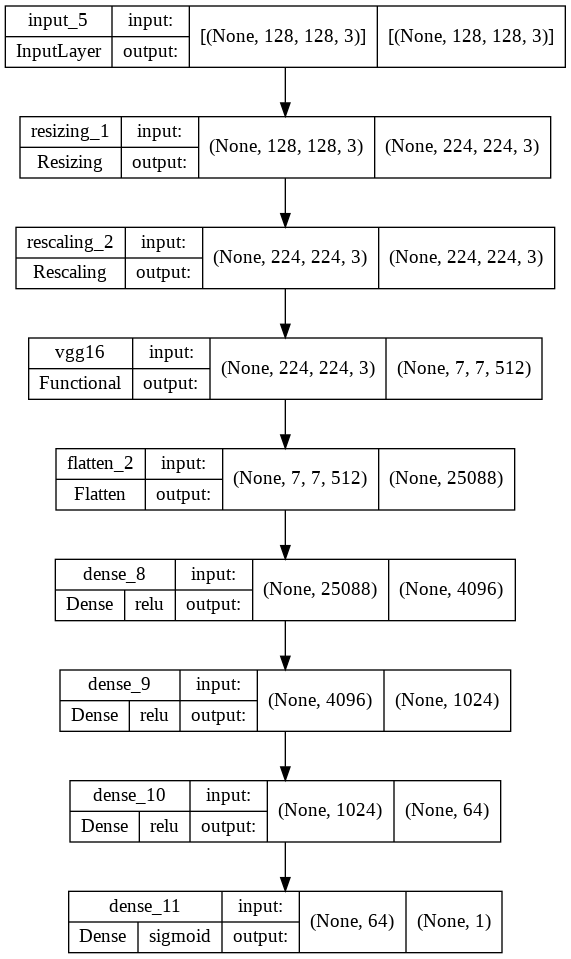

In [ ]:
# VGG model pre-trained on the imagenet has been taken as base model 
base_model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=1,
    classifier_activation='sigmoid'
)
base_model.trainable = True

# Defining preprocessing and vgg layers to make a functional model having pre-trained VGG model in its core
# Input layer taking images in its original size
input = tf.keras.layers.Input(shape=(128, 128, 3))
# Resizing images to be acceptable by the vgg model
resize = tf.keras.layers.Resizing(224, 224)(input)
# Scaling the pixels in the range of 0 to 1
scaling = tf.keras.layers.Rescaling(1./255)(resize)
# Taking the layers of the base model as part of the new model
z = base_model(scaling, training=True)
# Flattening the output from the model
flatten = tf.keras.layers.Flatten()(z)
# Finally adding dense layers with a single output for the binay classification
d = tf.keras.layers.Dense(4096, activation='relu')(flatten)
d = tf.keras.layers.Dense(1024, activation='relu')(d)
d = tf.keras.layers.Dense(64, activation='relu')(d)
# Final layer is having one neuron for with sigmoid activation for binary classification
output = tf.keras.layers.Dense(1, activation='sigmoid')(d)

# Finally building the model
new_vgg = tf.keras.Model(input, output)


# Using Multi-optimizer to make different layers of the base-model have different values of learning rate. 
# Defining the list of optimizers with different learning rates
optimizers = [
    tf.keras.optimizers.Adam(learning_rate=1e-6),
    tf.keras.optimizers.Adam(learning_rate=1e-4),
    tf.keras.optimizers.Adam(learning_rate=1e-2)]

# Making optimizer-layer pairs to form multi-optimizer 
optimizers_layers_tup = [(optimizers[0], base_model.layers[0:7]), (optimizers[1], base_model.layers[7:15]),\
                         (optimizers[1], base_model.layers[15:] + new_vgg.layers[:7] + new_vgg.layers[8:])]

# Finally defining the optimizer to be used in compiling the model
new_optimizer = tfa.optimizers.MultiOptimizer(optimizers_layers_tup)
# Compiling the model
new_vgg.compile(optimizer=new_optimizer, loss="binary_crossentropy", metrics=['accuracy'])
#Plotting model summary
tf.keras.utils.plot_model(
    new_vgg,
    show_shapes=True,
    show_layer_activations=True
)

### Training the model on the training data and evaluating on validation data
'prefetch' is used for optimal performace and 10 epochs were enough for the model to give appropriate level of accuracy in predictions. 

Epoch 1/5
313/313 [==============================] - 155s 479ms/step - loss: 0.4301 - accuracy: 0.8005 - val_loss: 0.2256 - val_accuracy: 0.9060
Epoch 2/5
313/313 [==============================] - 152s 476ms/step - loss: 0.2703 - accuracy: 0.8953 - val_loss: 0.2247 - val_accuracy: 0.9085
Epoch 3/5
313/313 [==============================] - 152s 476ms/step - loss: 0.2302 - accuracy: 0.9139 - val_loss: 0.1610 - val_accuracy: 0.9370
Epoch 4/5
313/313 [==============================] - 152s 476ms/step - loss: 0.1874 - accuracy: 0.9313 - val_loss: 0.1379 - val_accuracy: 0.9505
Epoch 5/5
313/313 [==============================] - 152s 475ms/step - loss: 0.1592 - accuracy: 0.9419 - val_loss: 0.1457 - val_accuracy: 0.9510


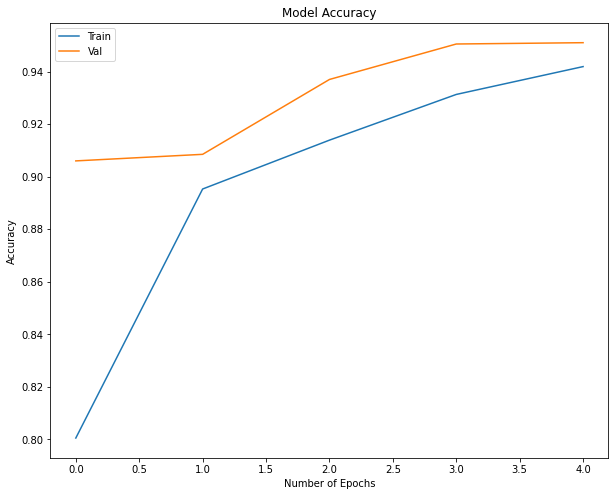

In [ ]:
# Training the model on training set and validating on validation set
# Using prefetch to distribute the task optimally between cpu and gpu.
with tf.device('/gpu:0'):
  history_vgg = new_vgg.fit(train_ds.prefetch(1), 
                          epochs=5, validation_data = val_ds.prefetch(1), verbose=1)

plt.figure(figsize=(10,8))
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Performance on test sets

Evaluating the model on Balanced and Unbalanced Test set

In [ ]:
# Evaluating on the test sets
test_result_vgg = new_vgg.evaluate(test_ds.prefetch(1))
unbalanced_test_result_vgg = new_vgg.evaluate(test_unb_ds.prefetch(1))

print('\nAccuracy on balanced test set is ',test_result_vgg[1])
print('Accuracy on unbalanced test set is ',unbalanced_test_result_vgg[1])

282/282 [==============================] - 44s 157ms/step - loss: 0.2470 - accuracy: 0.9059

Accuracy on balanced test set is  0.9384999871253967
Accuracy on unbalanced test set is  0.9058889150619507


Testing the model performance using different metrics of evaluation

,Precision,Recall,F1_Score,ROC_AUC_Score,Accuracy Score
Unbalanced Data,0.542289,0.981,0.698469,0.93875,0.905889


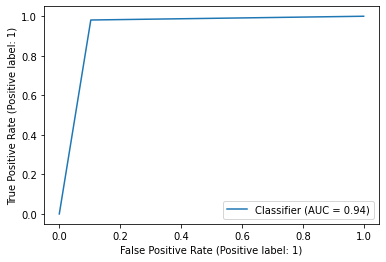

In [ ]:
# Prediction of the model on the balanced test set
test_prediction_vgg_proba = new_vgg.predict(test_ds.prefetch(1)).reshape(-1,)
# Converting probabilities to classes (since obatined labels are in that form)
test_prediction_vgg = [np.round(i) for i in test_prediction_vgg_proba]
# Prediction of the model on the unbalanced test set
unb_test_prediction_vgg_proba = new_vgg.predict(test_unb_ds.prefetch(1)).reshape(-1,)
# Converting probabilities to classes
unb_test_prediction_vgg = [np.round(i) for i in unb_test_prediction_vgg_proba]


# Report for Balanaced Test Set
accuracy_vgg = accuracy_score(y_true, test_prediction_vgg)

# Report for Unbalanaced Test Set using different metrics 
precision_vgg_unb = precision_score(y_true_unb, unb_test_prediction_vgg)
recall_vgg_unb = recall_score(y_true_unb, unb_test_prediction_vgg)
f1_vgg_unb = f1_score(y_true_unb, unb_test_prediction_vgg)
roc_auc_vgg_unb = roc_auc_score(y_true_unb, unb_test_prediction_vgg)
accuracy_vgg_unb = accuracy_score(y_true_unb, unb_test_prediction_vgg)

# Making a dictionary and a pandas dataframe to display the performance of model on unbalanced dataset
vgg_predict = {'Precision': [precision_vgg_unb], 'Recall': [recall_vgg_unb], 'F1_Score': [f1_vgg_unb], \
               'ROC_AUC_Score': [roc_auc_vgg_unb], 'Accuracy Score': [accuracy_vgg_unb]}
vgg_report = pd.DataFrame(vgg_predict).rename(index = {0:'Unbalanced Data'})
display(vgg_report)

# ROC_AUC_Curve display
RocCurveDisplay.from_predictions(y_true_unb, unb_test_prediction_vgg)
plt.show()

# Saving the predictions and report for future use
np.save('/content/drive/MyDrive/AI2_Project/Predictions/unb_test_prediction_vgg.npy', unb_test_prediction_vgg, allow_pickle=True)
np.save('/content/drive/MyDrive/AI2_Project/Predictions/test_prediction_vgg.npy', test_prediction_vgg, allow_pickle=True)
vgg_report.to_csv('/content/drive/MyDrive/AI2_Project/Predictions/vgg_report.csv', index=False)

# **ResNet Model (Pretrained)**
1.   Model Architecture Construction around pretrained ResNet (pretrained on 'Imagenet') 
2.   Model training on training set and validation on validation set
3.   Evaluating predictions on test sets: Accuracy, F1 Score, ROC_AUC, Precision and Recall are used as evaluation metrics.

### Model Architecture with pretrained resnet at its core
This model is also trained on 'imagenet' dataset but gave good train-validation accuracy. Model architecture is same as for VGGNet but due to having a 175 layers, assignment of optimizer with different learning rates is done differently for this model to adjust for the increase in number of layers.

94781440/94765736 [==============================] - 0s 0us/step


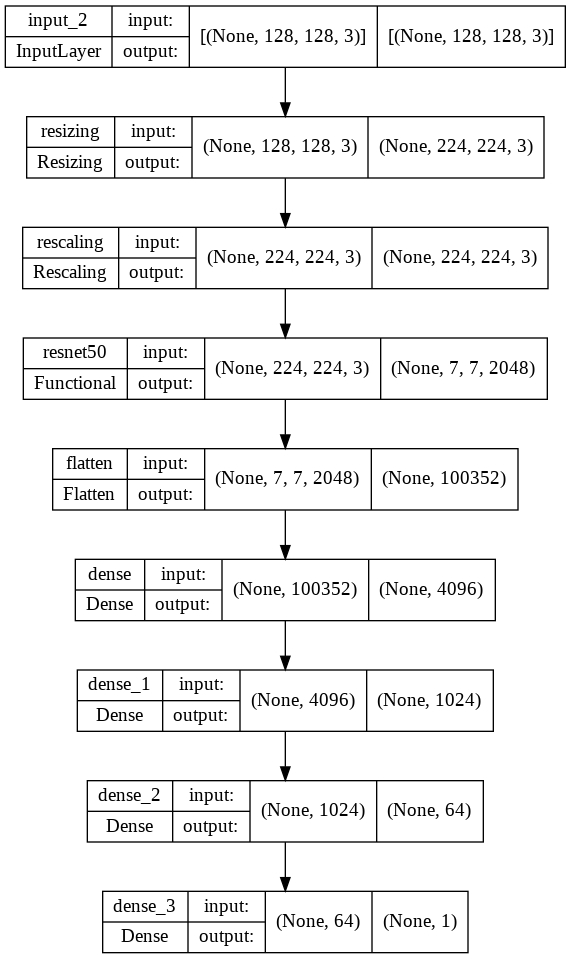

In [ ]:
# VGG model pre-trained on the imagenet has been taken as base model 
resnet = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=1,
    classifier_activation='sigmoid'
)

# Defining preprocessing and vgg layers to make a functional model having pre-trained VGG model in its core
# Input layer taking images in its original size
input = tf.keras.layers.Input(shape=(128, 128, 3))
# Resizing images to be acceptable by the vgg model
resize = tf.keras.layers.Resizing(224, 224)(input)
# Scaling the pixels in the range of 0 to 1
scaling = tf.keras.layers.Rescaling(1./255)(resize)
# Taking the layers of the base model as part of the new model
z = resnet(scaling, training=True)
# Flattening the output from the model
flatten = tf.keras.layers.Flatten()(z)
# Finally adding dense layers with a single output for the binay classification
d = tf.keras.layers.Dense(4096, activation='relu')(flatten)
d = tf.keras.layers.Dense(1024, activation='relu')(d)
d = tf.keras.layers.Dense(64, activation='relu')(d)
# Final layer is having one neuron for with sigmoid activation for binary classification
output = tf.keras.layers.Dense(1, activation='sigmoid')(d)

# Finally building the model
new_resnet = tf.keras.Model(input, output)


# Using Multi-optimizer to make different layers of the base-model have different values of learning rate. 
# Defining the list of optimizers with different learning rates
optimizers = [
    tf.keras.optimizers.Adam(learning_rate=1e-6),
    tf.keras.optimizers.Adam(learning_rate=1e-4),
    tf.keras.optimizers.Adam(learning_rate=1e-2)]

# Making optimizer-layer pairs to form multi-optimizer 
optimizers_layers_tup = [(optimizers[0], resnet.layers[0:50]), (optimizers[1], resnet.layers[50:100]),\
                         (optimizers[1], resnet.layers[100:] + new_resnet.layers[:7] + new_resnet.layers[8:])]

# Finally defining the optimizer to be used in compiling the model
new_optimizer = tfa.optimizers.MultiOptimizer(optimizers_layers_tup)
# Compiling the model
new_resnet.compile(optimizer=new_optimizer, loss="binary_crossentropy", metrics=['accuracy'])
#Plotting model summary
tf.keras.utils.plot_model(
    new_resnet,
    show_shapes=True
)

### Training the model
'prefetch' is used for optimal performace and 10 epochs were enough for the model to give appropriate level of accuracy in predictions. Model was trained on training dataset and validated on validation dataset.

Epoch 1/10
313/313 [==============================] - 874s 3s/step - loss: 0.2047 - accuracy: 0.9279 - val_loss: 0.5986 - val_accuracy: 0.8965
Epoch 2/10
313/313 [==============================] - 147s 458ms/step - loss: 0.0826 - accuracy: 0.9698 - val_loss: 0.1063 - val_accuracy: 0.9685
Epoch 3/10
313/313 [==============================] - 146s 457ms/step - loss: 0.0786 - accuracy: 0.9724 - val_loss: 0.3544 - val_accuracy: 0.9145
Epoch 4/10
313/313 [==============================] - 146s 457ms/step - loss: 0.0689 - accuracy: 0.9762 - val_loss: 0.0893 - val_accuracy: 0.9705
Epoch 5/10
313/313 [==============================] - 146s 456ms/step - loss: 0.0701 - accuracy: 0.9756 - val_loss: 0.2203 - val_accuracy: 0.9415
Epoch 6/10
313/313 [==============================] - 149s 465ms/step - loss: 0.0558 - accuracy: 0.9803 - val_loss: 0.0717 - val_accuracy: 0.9785
Epoch 7/10
313/313 [==============================] - 146s 456ms/step - loss: 0.0624 - accuracy: 0.9784 - val_loss: 0.1746 - va

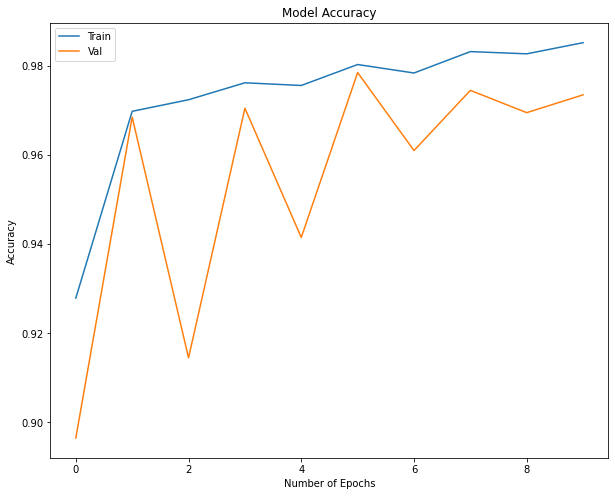

In [ ]:
# Training the model on training set and validating on validation set
# Using prefetch to distribute the task optimally between cpu and gpu.
with tf.device('/gpu:0'):
  history_resnet = new_resnet.fit(train_ds.prefetch(1), epochs=10, validation_data = val_ds.prefetch(1), verbose=1)

plt.figure(figsize=(10,8))
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Performance on test sets

Evaluating the model on Balanced and Unbalanced Test set

In [ ]:
# Evaluating on the test sets
test_result_res = new_resnet.evaluate(test_ds.prefetch(1))
unbalanced_test_result_res = new_resnet.evaluate(test_unb_ds.prefetch(1))

print('\nAccuracy on balanced test set is ',test_result_res[1])
print('Accuracy on unbalanced test set is ',unbalanced_test_result_res[1])

282/282 [==============================] - 219s 779ms/step - loss: 1.6663 - accuracy: 0.7287

Accuracy on balanced test set is  0.9760000109672546
Accuracy on unbalanced test set is  0.7286666631698608


Testing the model performance using different metrics of evaluation

,Precision,Recall,F1_Score,ROC_AUC_Score,Accuracy Score
Unbalanced Data,0.289058,0.988,0.447261,0.842125,0.728667


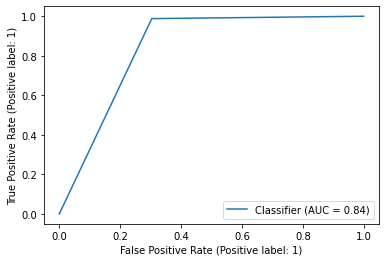

In [ ]:
# Prediction of the model on the balanced test set
test_prediction_res_proba = new_resnet.predict(test_ds.prefetch(1)).reshape(-1,)
# Converting probabilities to classes 
test_prediction_res = [np.round(i) for i in test_prediction_res_proba]
# Prediction of the model on the unbalanced test set
unb_test_prediction_res_proba = new_resnet.predict(test_unb_ds.prefetch(1)).reshape(-1,)
# Converting probabilities to classes
unb_test_prediction_res = [np.round(i) for i in unb_test_prediction_res_proba]

# Report for Balanaced Test Set
accuracy_vgg = accuracy_score(y_true, test_prediction_res)

# Report for Unbalanaced Test Set using different metrics of evaluation
precision_res_unb = precision_score(y_true_unb, unb_test_prediction_res)
recall_res_unb = recall_score(y_true_unb, unb_test_prediction_res)
f1_res_unb = f1_score(y_true_unb, unb_test_prediction_res)
roc_auc_res_unb = roc_auc_score(y_true_unb, unb_test_prediction_res)
accuracy_res_unb = accuracy_score(y_true_unb, unb_test_prediction_res)

# Making a dictionary and a pandas dataframe to display the performance of model on unbalanced dataset
res_predict = {'Precision': [precision_res_unb], 'Recall': [recall_res_unb], 'F1_Score': [f1_res_unb], \
               'ROC_AUC_Score': [roc_auc_res_unb], 'Accuracy Score': [accuracy_res_unb]}
res_report = pd.DataFrame(res_predict).rename(index = {0:'Unbalanced Data'})
display(res_report)

# ROC_AUC_Curve display
RocCurveDisplay.from_predictions(y_true_unb, unb_test_prediction_res)
plt.show()

# Saving the predictions and report for future use
np.save('/content/drive/MyDrive/AI2_Project/Predictions/unb_test_prediction_res.npy', unb_test_prediction_res, allow_pickle=True)
np.save('/content/drive/MyDrive/AI2_Project/Predictions/test_prediction_res.npy', test_prediction_res, allow_pickle=True)
res_report.to_csv('/content/drive/MyDrive/AI2_Project/Predictions/res_report.csv', index=False)

# **Inception Model (Pretrained)**
1.   Model Architecture Construction around pretrained **Inception** model (pretrained on 'Imagenet') 
2.   Model training on training set and validation on validation set
3.   Evaluating predictions on test sets: For unbalanced dataset, metrics used are roc auc, f1, precision and recall.

### Model Architecture with pretrained Inception at its core
This model is having 311 layers, thus using MultiOptimizer a learning rate of 0.000001 has been assigned to first 120 layers, l_rate of 0.0001 to layers from 120 to 270 and l_rate of 0.001 to the last convolutional layers of incep and the top dense layers of the model.

87924736/87910968 [==============================] - 0s 0us/step


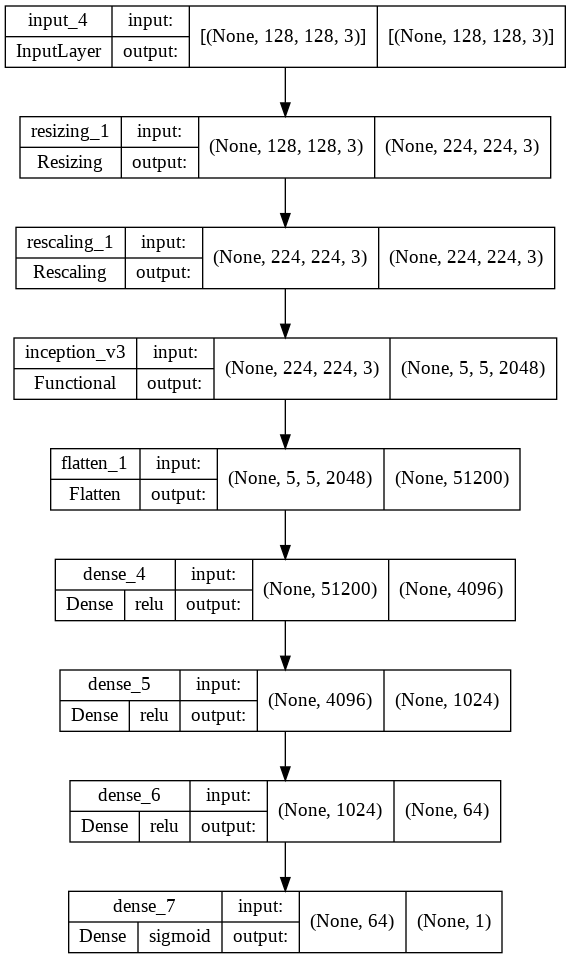

In [ ]:
# Inception model pre-trained on the imagenet has been taken as base model 
incep = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    # pooling=None,
    # classes=1,
    # classifier_activation='sigmoid'
)

# Defining preprocessing and vgg layers to make a functional model having pre-trained VGG model in its core
# Input layer taking images in its original size
input = tf.keras.layers.Input(shape=(128, 128, 3))
# Resizing images to be acceptable by the vgg model
resize = tf.keras.layers.Resizing(224, 224)(input)
# Scaling the pixels in the range of 0 to 1
scaling = tf.keras.layers.Rescaling(1./255)(resize)
# Taking the layers of the base model as part of the new model
z = incep(scaling, training=True)
# Flattening the output from the model
flatten = tf.keras.layers.Flatten()(z)
# Finally adding dense layers with a single output for the binay classification
d = tf.keras.layers.Dense(4096, activation='relu')(flatten)
d = tf.keras.layers.Dense(1024, activation='relu')(d)
d = tf.keras.layers.Dense(64, activation='relu')(d)
output = tf.keras.layers.Dense(1, activation='sigmoid')(d)

# Finally building the model
new_incep = tf.keras.Model(input, output)


# Using Multi-optimizer to make different layers of the base-model have different values of learning rate. 
# Defining the list of optimizers with different learning rates
optimizers = [
    tf.keras.optimizers.Adam(learning_rate=1e-6),
    tf.keras.optimizers.Adam(learning_rate=1e-4),
    tf.keras.optimizers.Adam(learning_rate=1e-2)]

# Making optimizer-layer pairs to form multi-optimizer 
optimizers_layers_tup = [(optimizers[0], incep.layers[0:120]), (optimizers[1], incep.layers[120:270]),\
                         (optimizers[1], incep.layers[270:] + new_incep.layers[:7] + new_incep.layers[8:])]

# Finally defining the optimizer to be used in compiling the model
new_optimizer = tfa.optimizers.MultiOptimizer(optimizers_layers_tup)
# Compiling the model
new_incep.compile(optimizer=new_optimizer, loss="binary_crossentropy", metrics=['accuracy'])
#Plotting model summary
tf.keras.utils.plot_model(
    new_incep,
    show_shapes=True,
    show_layer_activations=True
)

### Training the model
'prefetch' is used for optimal performace and 10 epochs were enough for the model to give appropriate level of accuracy in predictions. Model was trained on training dataset and validated on validation dataset.

Epoch 1/10
313/313 [==============================] - 121s 340ms/step - loss: 0.1886 - accuracy: 0.9197 - val_loss: 0.1527 - val_accuracy: 0.9505
Epoch 2/10
313/313 [==============================] - 105s 326ms/step - loss: 0.0989 - accuracy: 0.9632 - val_loss: 0.1392 - val_accuracy: 0.9475
Epoch 3/10
313/313 [==============================] - 106s 326ms/step - loss: 0.0663 - accuracy: 0.9745 - val_loss: 0.2394 - val_accuracy: 0.9405
Epoch 4/10
313/313 [==============================] - 105s 326ms/step - loss: 0.0577 - accuracy: 0.9782 - val_loss: 0.1244 - val_accuracy: 0.9650
Epoch 5/10
313/313 [==============================] - 105s 325ms/step - loss: 0.0450 - accuracy: 0.9832 - val_loss: 0.1767 - val_accuracy: 0.9300
Epoch 6/10
313/313 [==============================] - 105s 325ms/step - loss: 0.0429 - accuracy: 0.9824 - val_loss: 0.2203 - val_accuracy: 0.9420
Epoch 7/10
313/313 [==============================] - 105s 325ms/step - loss: 0.0385 - accuracy: 0.9867 - val_loss: 0.1605 -

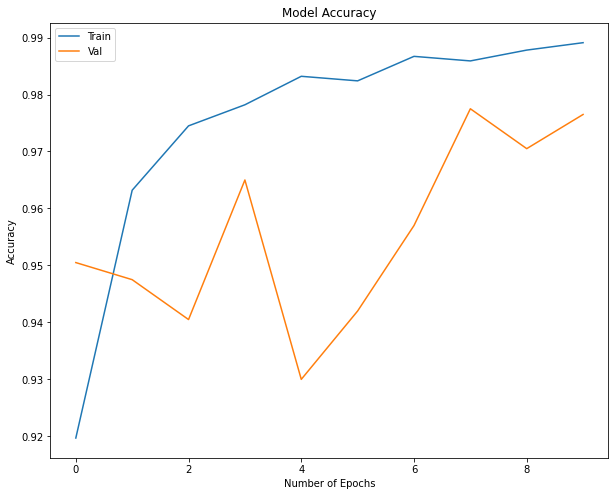

In [ ]:
# Training the model on training set and validating on validation set
# Using prefetch to distribute the task optimally between cpu and gpu.
with tf.device('/gpu:0'):
  history_incep = new_incep.fit(train_ds.prefetch(1), epochs=10, validation_data = val_ds.prefetch(1), verbose=1)

plt.figure(figsize=(10,8))
plt.plot(history_incep.history['accuracy'])
plt.plot(history_incep.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Performance on test sets

Evaluating the model on Balanced and Unbalanced Test set

In [ ]:
# Evaluating on the test sets
test_result_incep = new_incep.evaluate(test_ds.prefetch(1))
unbalanced_test_result_incep = new_incep.evaluate(test_unb_ds.prefetch(1))

print('\nAccuracy on balanced test set is ',test_result_incep[1])
print('Accuracy on unbalanced test set is ',unbalanced_test_result_incep[1],'\n\n')

282/282 [==============================] - 25s 87ms/step - loss: 2.1780 - accuracy: 0.6440

Accuracy on balanced test set is  0.9785000085830688
Accuracy on unbalanced test set is  0.6439999938011169 




Testing the model performance using different metrics of evaluation

,Precision,Recall,F1_Score,ROC_AUC_Score,Accuracy Score
Unbalanced Data,0.289058,0.988,0.447261,0.842125,0.728667


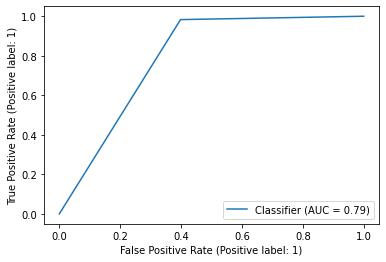

In [ ]:
# Prediction of the model on the balanced test set
test_prediction_incep_proba = new_incep.predict(test_ds.prefetch(1)).reshape(-1,)
# Converting probabilities to classes 
test_prediction_incep = [np.round(i) for i in test_prediction_incep_proba]
# Prediction of the model on the unbalanced test set
unb_test_prediction_incep_proba = new_incep.predict(test_unb_ds.prefetch(1)).reshape(-1,)
# Converting probabilities to classes 
unb_test_prediction_incep = [np.round(i) for i in unb_test_prediction_incep_proba]

# Report for Balanaced Test Set
accuracy_incep = accuracy_score(y_true, test_prediction_incep)

# Report for Unbalanaced Test Set using various metrics of unbalanced prediction evaluation
precision_incep_unb = precision_score(y_true_unb, unb_test_prediction_incep)
recall_incep_unb = recall_score(y_true_unb, unb_test_prediction_incep)
f1_incep_unb = f1_score(y_true_unb, unb_test_prediction_incep)
roc_auc_incep_unb = roc_auc_score(y_true_unb, unb_test_prediction_incep)
accuracy_incep_unb = accuracy_score(y_true_unb, unb_test_prediction_incep)

# Making a dictionary and a pandas dataframe to display the performance of model on unbalanced dataset
incep_predict = {'Precision': [precision_incep_unb], 'Recall': [recall_incep_unb], 'F1_Score': [f1_incep_unb], \
               'ROC_AUC_Score': [roc_auc_incep_unb], 'Accuracy Score': [accuracy_incep_unb]}
incep_report = pd.DataFrame(res_predict).rename(index = {0:'Unbalanced Data'})
display(incep_report)

# ROC_AUC_Curve display
RocCurveDisplay.from_predictions(y_true_unb, unb_test_prediction_incep)
plt.show()

# Saving the predictions and report for future use
np.save('/content/drive/MyDrive/AI2_Project/Predictions/unb_test_prediction_incep.npy', unb_test_prediction_incep, allow_pickle=True)
np.save('/content/drive/MyDrive/AI2_Project/Predictions/test_prediction_incep.npy', test_prediction_incep, allow_pickle=True)
incep_report.to_csv('/content/drive/MyDrive/AI2_Project/Predictions/incep_report.csv', index=False)

# **Results**


1.   Importing previously saved predictions and scores
2.   Plotting different evaluation metrices for model performance on unbalanced dataset
3.   Plotting accuracy of models on balanced testset
4.   Confusion Matrices of predictions for unbalanced and balanced testsets.



### Importing Saved Predictions and Scores

In [ ]:
# Loading true labels
y_true = np.load('/content/drive/MyDrive/AI2_Project/Predictions/y_true.npy', allow_pickle=True)
y_true_unb = np.load('/content/drive/MyDrive/AI2_Project/Predictions/y_true_unb.npy', allow_pickle=True)

# Loading vgg predictions
test_prediction_vgg = np.load('/content/drive/MyDrive/AI2_Project/Predictions/test_prediction_vgg.npy', allow_pickle=True)
unb_test_prediction_vgg = np.load('/content/drive/MyDrive/AI2_Project/Predictions/unb_test_prediction_vgg.npy', allow_pickle=True)

# Loading resnet predictions
test_prediction_res = np.load('/content/drive/MyDrive/AI2_Project/Predictions/test_prediction_res.npy', allow_pickle=True)
unb_test_prediction_res = np.load('/content/drive/MyDrive/AI2_Project/Predictions/unb_test_prediction_res.npy', allow_pickle=True)

# Loading incep predictions
test_prediction_incep = np.load('/content/drive/MyDrive/AI2_Project/Predictions/test_prediction_incep.npy', allow_pickle=True)
unb_test_prediction_incep = np.load('/content/drive/MyDrive/AI2_Project/Predictions/unb_test_prediction_incep.npy', allow_pickle=True)

# Loading custom model predictions
test_prediction_custom = np.load('/content/drive/MyDrive/AI2_Project/Predictions/test_prediction_custom.npy', allow_pickle=True)
unb_test_prediction_custom = np.load('/content/drive/MyDrive/AI2_Project/Predictions/unb_test_prediction_custom.npy', allow_pickle=True)

# Loading reports of different models 
custom_report = pd.read_csv('/content/drive/MyDrive/AI2_Project/Predictions/custom_report.csv')
vgg_report = pd.read_csv('/content/drive/MyDrive/AI2_Project/Predictions/vgg_report.csv')
res_report = pd.read_csv('/content/drive/MyDrive/AI2_Project/Predictions/res_report.csv')
incep_report = pd.read_csv('/content/drive/MyDrive/AI2_Project/Predictions/incep_report.csv')

### Performance of Model on Unbalanced Testset (Accuracy plots)

,Precision,Recall,F1_Score,ROC_AUC_Score,Accuracy Score
Custom_Model,0.614760,0.833,0.707431,0.883875,0.923444
VGGNet,0.542289,0.981,0.698469,0.938750,0.905889
ResNet,0.289058,0.988,0.447261,0.842125,0.728667
Inception,0.289058,0.988,0.447261,0.842125,0.728667


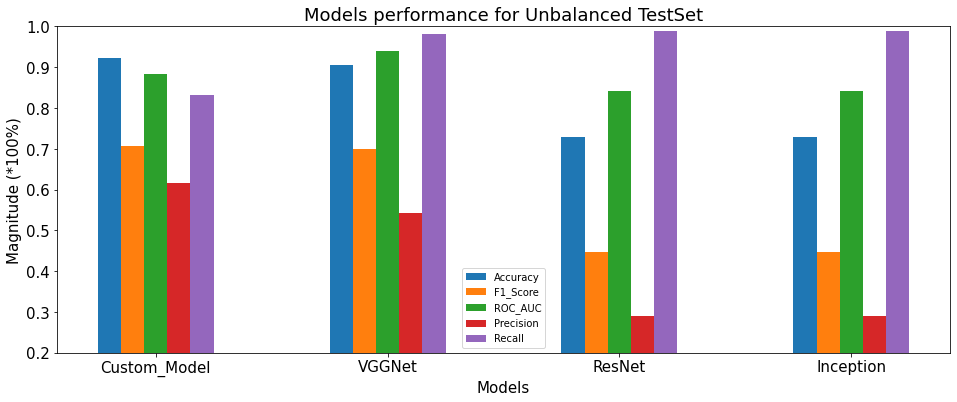

In [ ]:
# Concatenating different reports to form a single final report for display
report_f = pd.concat([custom_report, vgg_report, res_report, incep_report], axis=0, ignore_index=True)
report_f.rename(index={0:'Custom_Model', 1:'VGGNet', 2:'ResNet', 3:'Inception'}, inplace=True)
display(report_f)

# Obtaining scores in the format useful for plotting
models = list(report_f.index)
Precision = report_f['Precision'].values
Recall = report_f['Recall'].values
F1_Score = report_f['F1_Score'].values
ROC_AUC = report_f['ROC_AUC_Score'].values
Accuracy = report_f['Accuracy Score'].values

# Used in plotting
x_axis = np.arange(len(models))

#Plotting multi-bar chart for performance of models on unbalanced dtataset
fig = plt.figure(figsize=(16,6))

# Multi-bar Chart
plt.bar(x_axis -0.10*2, Accuracy, width=0.1, label = 'Accuracy')
plt.bar(x_axis -0.10, F1_Score, width=0.1, label = 'F1_Score')
plt.bar(x_axis   +0, ROC_AUC, width=0.1, label = 'ROC_AUC')
plt.bar(x_axis +0.10, Precision, width=0.1, label = 'Precision')
plt.bar(x_axis +0.10*2, Recall, width=0.1, label = 'Recall')

# Plot properties
plt.xticks(x_axis, models, fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0.2,1.0])
plt.legend()
plt.title('Models performance for Unbalanced TestSet', fontsize=18)
plt.xlabel('Models', fontsize=15)
plt.ylabel('Magnitude (*100%)', fontsize=15)
plt.show()

## Above Code has been taken with understanding from 
# https://pythonguides.com/matplotlib-multiple-bar-chart/#:~:text=arange()%20method%20is%20used,x%2Daxis%20to%20avoid%20overlapping.

### Performance on Balanced Testset (Accuracy Plots)


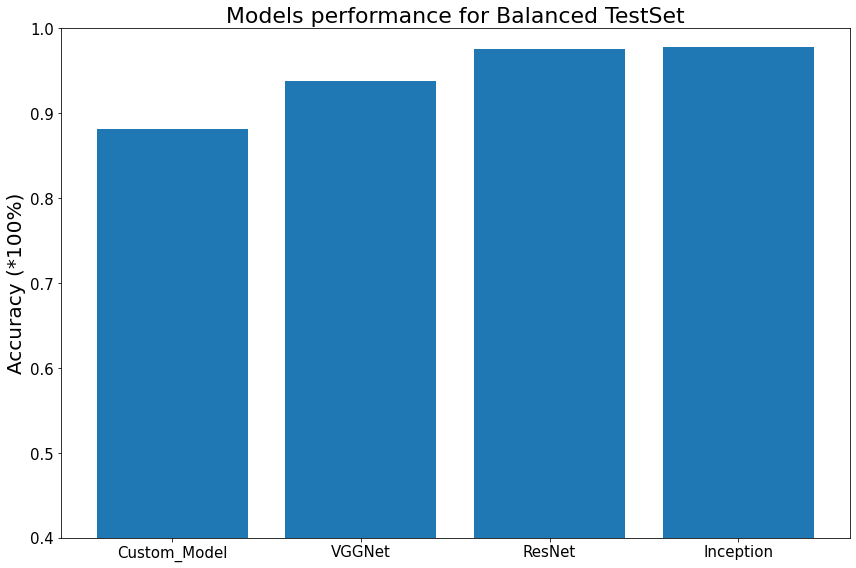

In [ ]:
# Report for Balanaced Test Set
accuracy_custom = accuracy_score(y_true, test_prediction_custom)
accuracy_vgg = accuracy_score(y_true, test_prediction_vgg)
accuracy_res = accuracy_score(y_true, test_prediction_res)
accuracy_incep = accuracy_score(y_true, test_prediction_incep)

# Plotting bar plot for balanced dataset for different models
plt.figure(figsize=(12,8))
plt.bar(x_axis, [accuracy_custom, accuracy_vgg, accuracy_res, accuracy_incep])
plt.xticks(x_axis, models, fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0.4,1])
plt.title('Models performance for Balanced TestSet', fontsize=22)
plt.ylabel('Accuracy (*100%)', fontsize=20)

plt.tight_layout()
# plt.savefig('Balanced_accuracy', dpi=1000)
plt.show()

### Confusion Matrices of Predictions from Different Models on Unbalanced Testset

Peformance of models on Unbalanced Dataset


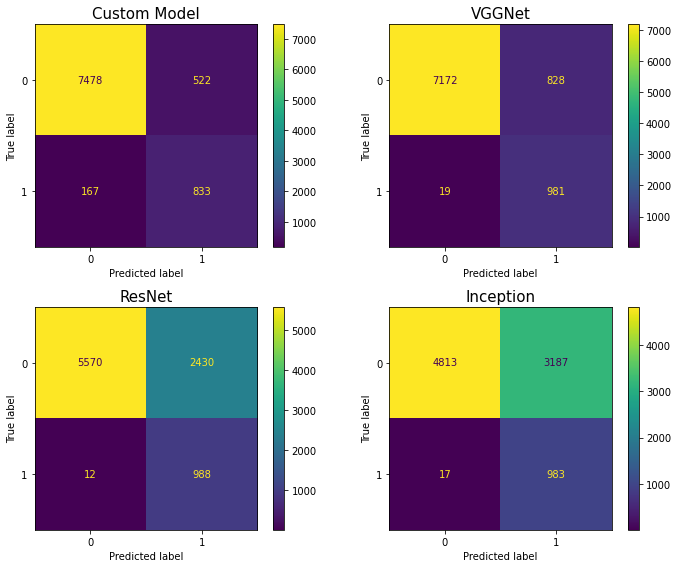

In [ ]:
# Forming different axes in the figure and setting the required title for each of them
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2,2,1)
ax.set_title('Custom Model', fontsize=15)
ax0 = fig.add_subplot(2,2,2)
ax0.set_title('VGGNet', fontsize=15)
ax1 = fig.add_subplot(2,2,3)
ax1.set_title('ResNet', fontsize=15)
ax2 = fig.add_subplot(2,2,4)
ax2.set_title('Inception', fontsize=15)

# Making confusion matrix and displaying them using confusionMatrixDisplay function in prespecified axes of the figure
# Custom Model
cm0 = confusion_matrix(y_true_unb, unb_test_prediction_custom)
ConfusionMatrixDisplay(cm0).plot(ax=ax)
# Pre-trained VGG Model
cm1 = confusion_matrix(y_true_unb, unb_test_prediction_vgg)
ConfusionMatrixDisplay(cm1).plot(ax=ax0)
# Pre-trained ResNet model
cm2 = confusion_matrix(y_true_unb, unb_test_prediction_res)
ConfusionMatrixDisplay(cm2).plot(ax=ax1)
# Pre-trained Inception model
cm3 = confusion_matrix(y_true_unb, unb_test_prediction_incep)
ConfusionMatrixDisplay(cm3).plot(ax=ax2)
# Displaying the final plot with super title
print('Peformance of models on Unbalanced Dataset')
plt.tight_layout()
plt.show()

### Confusion Matrices of Predictions from Different Models on Balanced Testset

Peformance of models on Balanced Dataset


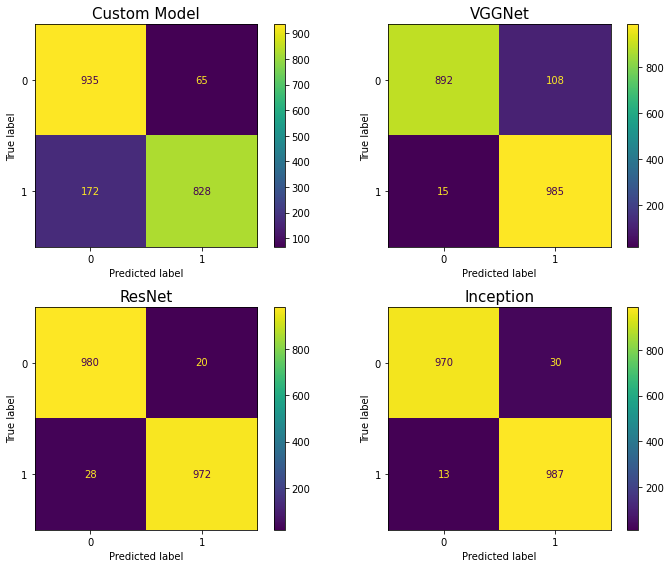

In [ ]:
# Forming different axes in the figure and setting the required title for each of them
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2,2,1)
ax.set_title('Custom Model', fontsize=15)
ax0 = fig.add_subplot(2,2,2)
ax0.set_title('VGGNet', fontsize=15)
ax1 = fig.add_subplot(2,2,3)
ax1.set_title('ResNet', fontsize=15)
ax2 = fig.add_subplot(2,2,4)
ax2.set_title('Inception', fontsize=15)

# Making confusion matrix and displaying them using confusionMatrixDisplay function in prespecified axes of the figure
# Custom Model
cm0 = confusion_matrix(y_true, test_prediction_custom)
ConfusionMatrixDisplay(cm0).plot(ax=ax)
# Pre-trained VGG Model
cm1 = confusion_matrix(y_true, test_prediction_vgg)
ConfusionMatrixDisplay(cm1).plot(ax=ax0)
# Pre-trained ResNet model
cm2 = confusion_matrix(y_true, test_prediction_res)
ConfusionMatrixDisplay(cm2).plot(ax=ax1)
# Pre-trained Inception model
cm3 = confusion_matrix(y_true, test_prediction_incep)
ConfusionMatrixDisplay(cm3).plot(ax=ax2)
# Displaying the final plot with super title
print('Peformance of models on Balanced Dataset')
plt.tight_layout()
plt.show()

# **Attention Visualization**
Using GradCam to understand where in the image model is focussing on to be able to classify it as damaged or undamaged.

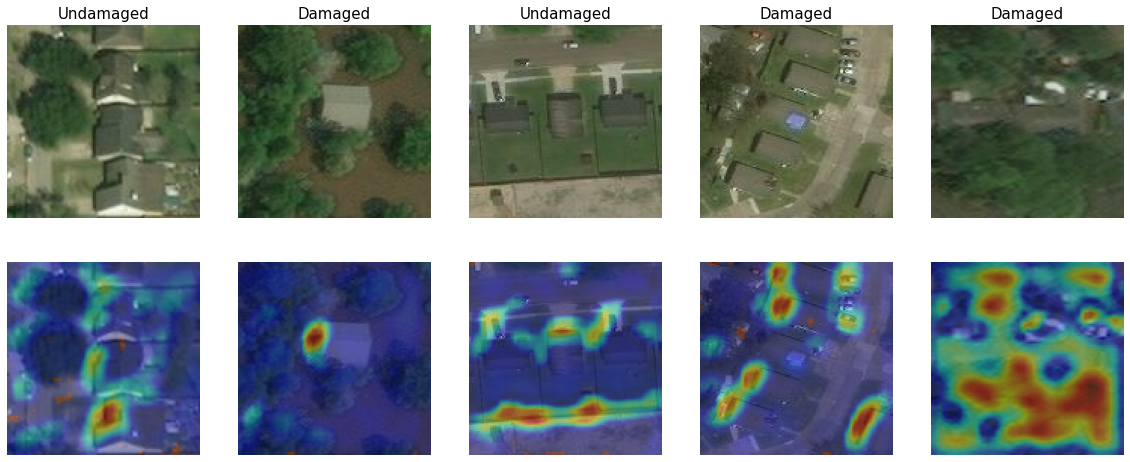

In [ ]:
import cv2

# Last convolution layer in the model is the last layer
conv_layer = model.layers[-12]
# Making a new model get_maps which gives outputs through two layers
map = tf.keras.models.Model(inputs = [model.inputs], outputs = [model.output, conv_layer.output])

# Taking a set of images from balanced test set
X = np.array([i[0] for i in test_ds.shuffle(1000, seed=42).take(2).unbatch().take(5)])
# Also taking labels for these images (by using same seed, same indices are obtained)
labels = np.array([i[1] for i in test_ds.shuffle(1000, seed=42).take(2).unbatch().take(5)])
label_names = ['Damaged', 'Undamaged']
# Taking an empty list to store obtained heatmaps
heatmaps = []

# Following code will be run 5 number of times, making gradcam for each of the image in the dataset
for x in X:
    # Dimension expanded (128,128,3) -> (1,128,128,3)
    x = np.expand_dims(x, 0)

    # Using tf.gradient to obtain gradient of class output with respect to output of last convolutional layer
    with tf.GradientTape() as tape:
        model_out, conv_layer = map(x)
        class_out = tf.reduce_max(model_out)
    gradients = tape.gradient(class_out, conv_layer)

    # Bringing the gradients in required size
    gradients = np.squeeze(np.array(gradients),axis=0)
    gradients = np.array([np.sum(gradients[:,:,i])/gradients[:,:,i].size for i in range(gradients.shape[2])])

    conv_layer = np.squeeze(np.array(conv_layer), axis=0)
    pooled_gradients = np.array([gradients[i]*conv_layer[:,:,i] for i in range(gradients.size)])
    heatmap = np.average(pooled_gradients, axis=0)
    # Normalizing the obtained heatmap after taking its absolute values
    heatmap = np.abs(heatmap)
    heatmap = (heatmap-np.min(heatmap))/(np.max(heatmap)-np.min(heatmap))
    # Bringing the heatmap into an appropriate size same as the actual image size
    resized_rescaled_heatmap = np.uint8(cv2.resize(heatmap,(128,128))*255)
    vals_array = np.uint8(256-resized_rescaled_heatmap)
    # Using OpenCV library to apply colours
    heatmap_final = cv2.applyColorMap(vals_array, cv2.COLORMAP_JET)
    # Appending the heatmap of the image in the list where other image's heatmaps are stored.
    heatmaps.append(heatmap_final)

# Plotting the obtained maps along with the original images
fig = plt.figure(figsize=(20,8))
for iter in range(1,6):
    ax0 = fig.add_subplot(2,5,iter)
    ax0.imshow(X[iter-1])
    ax0.axis('off')
    ax0.set_title(label_names[labels[iter-1]], fontsize=15)
for iter in range(6,11):
    ax0 = fig.add_subplot(2,5,iter)
    ax0.imshow(X[iter-6])
    ax0.imshow(heatmaps[iter-6], alpha=0.4)
    ax0.axis('off')
plt.show()

**EXPLANATION :** It is clear from the gradcam images that model focusses more on the boundaries of the buildings and comparatively less on the buildings itself. This makes sense because when looking from above only way to detect a damaged building is to see whether the building is surrounded by water. Thus by focussing on the boundaries of the buildings, model tries to detect the colour/texture at those boundaries and tries to detect if it is water or dry/green land, and on that basis it classifies the building as damaged or undamaged.

#**Conclusion** 


1.   **Inferences Drawn**
2.   **Future Works**



### **Inferences Drawn**
**From the performance on balanced dataset**, Inception has been the best performing model, followed by ResNet and VGGNet while our custom model somewhat performed poorly. For the custom model, 65 damaged buidlings were reported undamaged, for VGGNet, ResNet and Inception, these values are 108, 20 and 30 which is less with respect to total 2000 buildings. This means, damaged buildings will be more accurately spotted.
And, while the three transfer learning models labelled 15, 28 and 13 number of undamaged buildings as damaged, our custom model classified 935 undamaged buildings as damaged. This means the custom model, will get emergency managers to give assistnce to those house which is not even damaged (that too in higher numbers). But this can be tolerated to some extent. Overall performance of transfer learning models have been better with respect to the custom model on the balanced dataset. <br>
**From the performance on unbalanced dataset**, scenario is kind of reversed. Custom model became the model with overall better performance on different metrics of evaluation, performances of ResNet and Inception models have been terribly worse. VGGNet is still performing good and is comparabel to the performance of the custom model. But with respect to safety in real world, custom model seemed to perform best as it classify among others less number of damaged buildings as undamaged. Other models report very high number of damaged buildings as undamaged which is not a good sign.<br>
Final conclusion from the model performances would be that such models are deployable only if some other methods are also used along with this. Model accuracies need to be improved by either training it on more dataset or taking models pretrained on saellite images.

### **Future Works**
**Use of Hurricane delta:** This dataset as instructed, contains large scale images of whole hurricane damaged area. From these large scale images, localities with buildings can be extracted as squared size images. These new images can either be used for more training on our models, or can be used to see what our models predict. Due to time constraint and lack of relevant knowledge, we decided to drop this idea for now and add it to our future works. <br>
**Transfer learning models pretrained on geospatial image datasets:** Models were trained on 'Imagenet', but we did classification of satellite images which is not much close to the Imagenet dataset, even though the performance was good. Those models which have been pretrained on datasets like 'BigEarthNet' (https://bigearth.net/) will be best suited for classification in this case using transfer learning. We tried downloading model weights from https://git.tu-berlin.de/rsim/BigEarthNet-MM_19-classes_models and assigning it to our model, but due to version differences it didn't worked out this time. Peformance of such model will no doubt be the best of all which we will address in our future work on this project. <br>